# NLP: проект “Spam / Not Spam” (TF‑IDF + LogisticRegression)

**Цель урока:** за одно занятие пройти полный путь решения NLP‑задачи классификации текста:  
✅ загрузка данных → ✅ минимальный EDA → ✅ preprocessing → ✅ TF‑IDF → ✅ обучение модели → ✅ оценка → ✅ подбор порога → ✅ сохранение и тестирование модели.

**Датасет:** SMS Spam Collection (spam / ham)  
Источник: UCI ML Repository (id=228).

---

## Что вы поймёте после урока
1) Что такое NLP и почему “текст = числа”  
2) Как устроен **pipeline** решения текстовой задачи  
3) Что такое **TF‑IDF**
4) Как обучить **LogisticRegression** и оценить качество  
5) Как менять **порог**
6) Как сохранить модель и применять её к новым сообщениям

---


In [54]:
# Если запускаете на локальном ПК и чего-то нет — установите:
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib ucimlrepo --quiet

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)

import joblib

np.random.seed(42)
sns.set_style("whitegrid")

print("Ready ✅")

Ready ✅


# 1) Ввод: что такое NLP и как “машина понимает текст”

## NLP (Natural Language Processing)
Это область, где мы учим компьютер работать с человеческим языком:
- классификация текста (спам/не спам, токсичность, тема текста)
- поиск похожих текстов
- перевод
- суммаризация

---

## Маленькая история
- **1950-е**: вопрос “может ли машина думать?” (Тьюринг)
- **1980–2000-е**: статистические методы (частоты слов, n‑граммы)
- **2010-е**: мощный рост из‑за больших данных и GPU
- **сейчас**: нейросети, но **классические методы всё ещё полезны**

---

## Главная идея NLP
Компьютер не понимает буквы и слова.  
Он понимает **числа**.

Значит нам нужно сделать превращение:
**текст → признаки → модель**

Сегодня покажем самый популярный базовый способ:
✅ **TF‑IDF + LogisticRegression**


# 2) Пайплайн решения NLP‑задачи (шаблон для любого Kaggle)

Универсальный план действий:

1) **Загрузка датасета**
   - столбец с текстом
   - столбец с меткой класса (0/1)

2) **Мини‑EDA**
   - баланс классов (сколько спама?)
   - длина сообщений
   - примеры сообщений

3) **Preprocessing**
   - lower + убрать лишние символы
   - иногда: стоп‑слова, лемматизация

4) **Vectorization**
   - превращаем текст в числа
   - сегодня: **TF‑IDF**

5) **Train/Test split**

6) **Обучение модели** (LogisticRegression)

7) **Метрики**
   - accuracy, precision, recall, F1
   - confusion matrix

8) **Порог вероятности**
   - по умолчанию 0.5
   - но можно выбрать другой под задачу

9) **Сохранение модели**
   - сохраняем pipeline целиком
   - тестируем на новых текстах


In [55]:
import pandas as pd
import os

# 1. Get the path to your Downloads folder automatically
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")

# 2. Put your filename here (e.g., 'Youtube01-Psy.csv')
filename = r"C:\Users\nikak\Downloads\200k_news_category.csv" 
file_path = os.path.join(downloads_path, filename)

# 3. Load it into 'df'
df = pd.read_csv(file_path)

print(f"✅ Loaded local file: {filename}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
df.head()

✅ Loaded local file: C:\Users\nikak\Downloads\200k_news_category.csv
Rows: 210800, Columns: 4


,Unnamed: 0,title,content,category
0,0,Zareen Khan's lawyer issues statement on arres...,After a Kolkata court issued an arrest warrant...,Technology
1,1,"What is Women's Reservation Bill, demanded by ...",At an all-party meeting convened by the govern...,Politics
2,2,IIT Kanpur Director Abhay Karandikar appointed...,IIT Kanpur's Director Abhay Karandikar has bee...,Technology
3,3,Time stops for you: Mahindra as he praises PM ...,Mahindra Group Chairman Anand Mahindra took to...,Business
4,4,BJP MP Satish Dubey injured after car rams int...,BJP MP Satish Chandra Dubey and at least four ...,Politics


# 3) Загрузка датасета “Спам / Не спам”

Варианты:
✅ через `ucimlrepo` (если есть интернет)  
✅ fallback: мини‑датасет (если нет интернета)


In [56]:
!pip install ucimlrepo

In [57]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
youtube_spam_collection = fetch_ucirepo(id=380)

print("X columns:", X_raw.columns.tolist())
print("y columns:", y_raw.columns.tolist())

print("X shape:", X_raw.shape)
print("y shape:", y_raw.shape)

X_raw = youtube_spam_collection.data.features
y_raw = youtube_spam_collection.data.targets

df = pd.concat([X_raw, y_raw], axis=1)

df = df.rename(columns={
    "AUTHOR": "author",
    "DATE": "date",
    "CONTENT": "text",
    "CLASS": "label"
})

print(df.shape)
df.head()

X columns: ['AUTHOR', 'DATE', 'CONTENT']
y columns: ['CLASS']
X shape: (1956, 3)
y shape: (1956, 1)
(1956, 4)


,author,date,text,label
0,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


# 4) Мини‑EDA

Смотрим:
- баланс классов
- длины сообщений


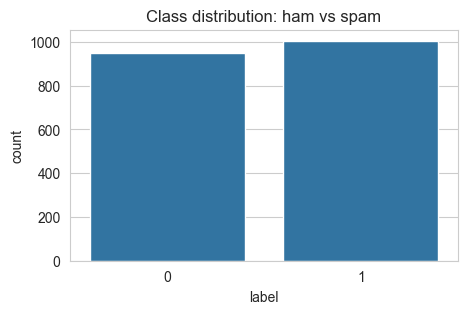

In [58]:
plt.figure(figsize=(5,3))
sns.countplot(x="label", data=df)
plt.title("Class distribution: ham vs spam")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

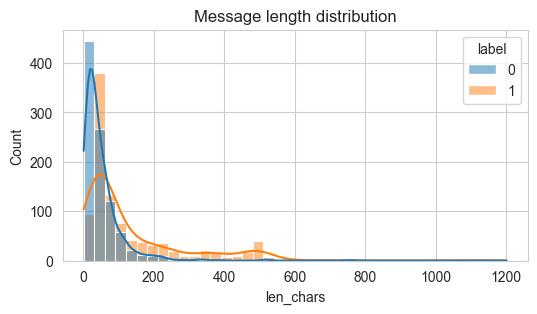

,label,text,len_chars
1360,0,Charlie from LOST?﻿,19
1703,0,BEST SONG EVER X3333333333﻿,27
1146,1,Aslamu Lykum... From Pakistan﻿,30
1758,1,I absolutely adore watching football plus I’ve...,487
374,1,I really love this video.. http://www.bubblews...,75


In [59]:
df["len_chars"] = df["text"].astype(str).apply(len)

plt.figure(figsize=(6,3))
sns.histplot(data=df, x="len_chars", hue="label", bins=40, kde=True)
plt.title("Message length distribution")
plt.xlabel("len_chars")
plt.show()

df[["label", "text", "len_chars"]].sample(5, random_state=42)

# 5) Preprocessing текста (минимально)

Базовая очистка:
- lower()
- убрать “не буквы/цифры/пробелы”
- убрать лишние пробелы


In [60]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["text"].apply(clean_text)
df[["text","text_clean"]].head(5)

,text,text_clean
0,"Huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...
1,Hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,just for test i have to say murdev com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,watch v vtarggvgtwq check this out


# 6) Train/Test split

`stratify=y` сохраняет долю классов в train и test.


In [61]:
X = df["text_clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train size:", len(X_train))
print("test size :", len(X_test))
print("train spam rate:", float(y_train.mean()))
print("test spam rate :", float(y_test.mean()))

train size: 1564
test size : 392
train spam rate: 0.5140664961636828
test spam rate : 0.5127551020408163


# 7) TF‑IDF + LogisticRegression

TF‑IDF превращает текст в числа, а логистическая регрессия решает бинарную классификацию.


In [62]:
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=8000,
        ngram_range=(1, 2)
    )),
    ("model", LogisticRegression(max_iter=2000)) # multi_class="multinomial", solver="lbfgs"
])

pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [63]:
pipe.fit(X_train, y_train)

pred_test = pipe.predict(X_test)

acc = accuracy_score(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
re = recall_score(y_test, pred_test, zero_division=0)
f1 = f1_score(y_test, pred_test, zero_division=0)

print("Test metrics:")
print("  accuracy :", round(acc, 4))
print("  precision:", round(prec, 4))
print("  recall   :", round(rec, 4))
print("  F1       :", round(f1, 4))

Test metrics:
  accuracy : 0.949
  precision: 0.9548


NameError: name 'rec' is not defined

In [ ]:
tfidf = pipe.named_steps["tfidf"]
print('Vocabulary size:',
      len(tfidf.get_feature_names_out()))
print(tfidf.get_feature_names_out()[200:300])

In [ ]:
print("Classification report:\n")
print(classification_report(y_test, pred_test, digits=3))

In [ ]:
cm = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm

# 8) Порог вероятности

`predict()` использует порог 0.5.  
Но можно менять порог и смотреть precision/recall.


In [ ]:
proba_test = pipe.predict_proba(X_test)[:, 1]

def predict_with_threshold(proba, thr=0.5):
    return (proba >= thr).astype(int)

for thr in [0.3, 0.5, 0.7, 0.9]:
    pred_thr = predict_with_threshold(proba_test, thr)
    f1_thr = f1_score(y_test, pred_thr, zero_division=0)
    rec_thr = recall_score(y_test, pred_thr, zero_division=0)
    prec_thr = precision_score(y_test, pred_thr, zero_division=0)
    print(f"thr={thr:.1f} | precision={prec_thr:.3f} recall={rec_thr:.3f} f1={f1_thr:.3f}")

# 9) Какие слова “тянут” в спам?

Смотрим веса логистической регрессии.


In [ ]:
tfidf = pipe.named_steps["tfidf"]
model = pipe.named_steps["model"]

feature_names = np.array(tfidf.get_feature_names_out())
coef = model.coef_.reshape(-1)

top_spam = np.argsort(coef)[-15:][::-1]
top_ham  = np.argsort(coef)[:15]

print("Top spam words/phrases:")
for idx in top_spam:
    print(f"{feature_names[idx]:<22} weight={coef[idx]:.3f}")

print("\nTop ham words/phrases:")
for idx in top_ham:
    print(f"{feature_names[idx]:<22} weight={coef[idx]:.3f}")

# 10) Сохранение и загрузка модели

Сохраняем pipeline целиком → потом используем на новых данных.


In [ ]:
MODEL_PATH = "/spam_tfidf_logreg_pipeline.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Saved:", MODEL_PATH)

In [ ]:
pipe_loaded = joblib.load(MODEL_PATH)

test_messages = [
    "Congratulations! You've won a free ticket. Reply YES to claim.",
    "Hey, are we still meeting at 6 today?",
    "URGENT: call now to get your reward!!!",
    "I love your videos. Without you I'll be dead"
]

proba = pipe_loaded.predict_proba(test_messages)[:, 1]
pred  = (proba >= 0.5).astype(int)

pd.DataFrame({
    "text": test_messages,
    "spam_proba": proba.round(3),
    "pred(0=ham,1=spam)": pred
})

---
# Итоги

✅ Полный проект сделан: загрузка → EDA → TF‑IDF → обучение → оценка → пороги → сохранение.


# 10 заданий на закрепление (код с пропусками)

Заполняйте `_____`.


## Задание 1

**Задание:** Сделайте столбец y: spam=1, ham=0.  
**Подсказка:** == 'spam'


In [67]:
df["label"] = df["label"].astype(str)
df["y"] = (df["label"].str.lower() == "1").astype(int)
df[["label","y"]].head()

,label,y
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


## Задание 2

**Задание:** Посчитайте долю спама.  
**Подсказка:** mean()


In [68]:
spam_rate = df["y"].mean()
print("spam rate:", round(spam_rate, 3))

spam rate: 0.514


## Задание 3

**Задание:** Добавьте длину сообщения.  
**Подсказка:** apply(len)


In [69]:
df["len_chars"] = df["text"].astype(str).apply(len)
df[["text","len_chars"]].head()

,text,len_chars
0,"Huh, anyway check out this you[tube] channel: ...",56
1,Hey guys check out my new channel and our firs...,166
2,just for test I have to say murdev.com,38
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,48
4,watch?v=vtaRGgvGtWQ Check this out .﻿,39


## Задание 4

**Задание:** Дописать clean_text.  
**Подсказка:** lower + re.sub


In [70]:
import re
def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

print(clean_text("FREE!!! win $$$ now!!!"))

free win now


## Задание 5

**Задание:** Train/test split со stratify.  
**Подсказка:** train_test_split(..., stratify=y)


In [71]:
from sklearn.model_selection import train_test_split
X = df["text_clean"]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    random_state=42,
    stratify=y
)
print(len(X_train), len(X_test))

978 978


## Задание 6

**Задание:** Pipeline TF‑IDF + LogReg.  
**Подсказка:** Pipeline + TfidfVectorizer + LogisticRegression


In [72]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
    ("model", LogisticRegression(max_iter=1000))
])
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


## Задание 7

**Задание:** Обучите и посчитайте accuracy.  
**Подсказка:** fit + predict + accuracy_score


In [73]:
from sklearn.metrics import accuracy_score
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print("accuracy:", round(acc, 4))

accuracy: 0.9489


## Задание 8

**Задание:** Постройте confusion matrix heatmap.  
**Подсказка:** confusion_matrix + sns.heatmap


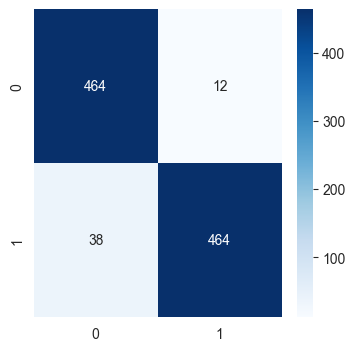

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

## Задание 9

**Задание:** Предсказания с порогом 0.7.  
**Подсказка:** predict_proba + thr


In [76]:
from sklearn.metrics import f1_score

proba = pipe.predict_proba(X_test)[:, 1]
thr = 0.7
pred_thr = (proba >= thr).astype(int)

print("F1:", f1_score(y_test, pred_thr, zero_division=0))

F1: 0.8772321428571429


## Задание 10

**Задание:** Сохраните и загрузите pipeline.  
**Подсказка:** joblib.dump + joblib.load


In [78]:
import joblib
path = "my_spam_model.joblib"

joblib.dump(pipe, path)
pipe2 = joblib.load(path)

msg = ["Win free prize now!", "Let's meet tomorrow at 5"]
print(pipe2.predict(msg))

[1 0]
